<a href="https://colab.research.google.com/github/daniiomir/future_sales_prediction_kaggle/blob/master/sales_prediction_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost

     |████████████████████████████████| 64.8MB 62kB/s 


In [2]:
!ls drive/My\ Drive/Colab\ Notebooks/data_sales_prediction

item_categories.csv  sales_train.csv	    shops.csv
items.csv	     sample_submission.csv  test.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # for formating pandas values in float format (not ~1e+1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Check data

In [0]:
path = r"drive/My Drive/Colab Notebooks/data_sales_prediction/"

items_cat = pd.read_csv(path + "item_categories.csv")
items = pd.read_csv(path + "items.csv")
train = pd.read_csv(path + "sales_train.csv")
sample_sub = pd.read_csv(path + "sample_submission.csv")
shops = pd.read_csv(path + "shops.csv")
test = pd.read_csv(path + "test.csv")

In [5]:
items_cat.head() # we should watch on our data tables

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00000,1.00000
1,03.01.2013,0,25,2552,899.00000,1.00000
2,05.01.2013,0,25,2552,899.00000,-1.00000
3,06.01.2013,0,25,2554,1709.05000,1.00000
4,15.01.2013,0,25,2555,1099.00000,1.00000


In [8]:
sample_sub.head()

,ID,item_cnt_month
0,0,0.50000
1,1,0.50000
2,2,0.50000
3,3,0.50000
4,4,0.50000


In [9]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [10]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [11]:
items_cat.isnull().sum() # check for nulls

item_category_name    0
item_category_id      0
dtype: int64

In [12]:
items.isnull().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [13]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [14]:
shops.isnull().sum()

shop_name    0
shop_id      0
dtype: int64

In [15]:
test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

# Feature engineering

In [0]:
test_shops = test.shop_id.unique() # in train/test data we have shops/items that we doesn't have in train/test data 
train = train[train.shop_id.isin(test_shops)] # so... we should delete useless data
test_items = test.item_id.unique()
train = train[train.item_id.isin(test_items)]

In [0]:
def split_city(str):
  return str.split(sep=" ", maxsplit=1)[0]

def split_shop(str):
  return str.split(sep=" ", maxsplit=1)[1]

def split_item_cat1(str):
  return str.split(sep="-", maxsplit=1)[0]

def split_item_cat2(str):
  splitted = str.split(sep="-", maxsplit=1)
  if len(splitted) == 1:
    return "No info"
  else:
    return splitted[1]

def prepare_data(data): # function for merging data and reformating features
  full_items = items.merge(items_cat, left_on="item_category_id", right_on="item_category_id")
  full_data = data.merge(shops, left_on="shop_id", right_on="shop_id").merge(full_items, left_on="item_id", right_on="item_id")
  del full_items
  full_data['city'] = full_data['shop_name'].apply(split_city)
  full_data['new_shop_name'] = full_data['shop_name'].apply(split_shop)
  full_data['item_cat1'] = full_data['item_category_name'].apply(split_item_cat1)
  full_data['item_cat2'] = full_data['item_category_name'].apply(split_item_cat2)
  full_data.drop(['shop_id', 'item_id', 'shop_name', 'item_name', 'item_category_id', 'item_category_name'], axis=1, inplace=True)
  return full_data

In [18]:
%%time
new_train = prepare_data(train.copy())
new_test = prepare_data(test.copy())

CPU times: user 4.85 s, sys: 641 ms, total: 5.49 s
Wall time: 5.51 s


In [0]:
# adding some usefull features, normilize our Y values into range 0, 20 and delete some columns
new_test['date_block_num'] = 34
new_test.drop(['ID'], axis=1, inplace=True)
new_train.drop(['date'], axis=1, inplace=True)
new_train['item_cnt_day'] = new_train['item_cnt_day'].clip(0, 20)
new_train['month'] = new_train['date_block_num'] % 12
new_test['month'] = new_test['date_block_num'] % 12
new_train.drop(['item_price'], axis=1, inplace=True)

In [20]:
new_train

,date_block_num,item_cnt_day,city,new_shop_name,item_cat1,item_cat2,month
0,0,1.00000,Ярославль,"ТЦ ""Альтаир""",Кино,Blu-Ray,0
1,0,1.00000,Москва,"ТРК ""Атриум""",Кино,Blu-Ray,0
2,0,1.00000,Москва,"ТРК ""Атриум""",Кино,Blu-Ray,0
3,0,1.00000,Москва,"ТРК ""Атриум""",Кино,Blu-Ray,0
4,0,1.00000,Москва,"ТРК ""Атриум""",Кино,Blu-Ray,0
...,...,...,...,...,...,...,...
1224434,33,1.00000,Цифровой,склад 1С-Онлайн,Программы,Для дома и офиса (Цифра),9
1224435,33,1.00000,Цифровой,склад 1С-Онлайн,Программы,Для дома и офиса (Цифра),9
1224436,33,3.00000,Цифровой,склад 1С-Онлайн,Игры PC,Цифра,9
1224437,33,1.00000,Цифровой,склад 1С-Онлайн,Игры PC,Цифра,9


In [21]:
new_test

,city,new_shop_name,item_cat1,item_cat2,date_block_num,month
0,Вологда,"ТРЦ ""Мармелад""",Игры,PS3,34,10
1,Волжский,"ТЦ ""Волга Молл""",Игры,PS3,34,10
2,Воронеж,"(Плехановская, 13)",Игры,PS3,34,10
3,Балашиха,"ТРК ""Октябрь-Киномир""",Игры,PS3,34,10
4,Адыгея,"ТЦ ""Мега""",Игры,PS3,34,10
...,...,...,...,...,...,...
214195,Сергиев,"Посад ТЦ ""7Я""",Кино,Blu-Ray,34,10
214196,РостовНаДону,"ТЦ ""Мега""",Кино,Blu-Ray,34,10
214197,Самара,"ТЦ ""Мелодия""",Кино,Blu-Ray,34,10
214198,РостовНаДону,"ТРК ""Мегацентр Горизонт""",Кино,Blu-Ray,34,10


In [22]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1224439 entries, 0 to 1224438
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date_block_num  1224439 non-null  int64  
 1   item_cnt_day    1224439 non-null  float64
 2   city            1224439 non-null  object 
 3   new_shop_name   1224439 non-null  object 
 4   item_cat1       1224439 non-null  object 
 5   item_cat2       1224439 non-null  object 
 6   month           1224439 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 74.7+ MB


In [23]:
new_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   city            214200 non-null  object
 1   new_shop_name   214200 non-null  object
 2   item_cat1       214200 non-null  object
 3   item_cat2       214200 non-null  object
 4   date_block_num  214200 non-null  int64 
 5   month           214200 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 11.4+ MB


In [24]:
new_train.describe()

,date_block_num,item_cnt_day,month
count,1224439.00000,1224439.00000,1224439.00000
mean,19.35472,1.28759,5.62865
std,9.11072,1.36084,3.47005
min,0.00000,0.00000,0.00000
25%,12.00000,1.00000,3.00000
50%,21.00000,1.00000,6.00000
75%,27.00000,1.00000,9.00000
max,33.00000,20.00000,11.00000


In [0]:
X_train = new_train.drop(['item_cnt_day'], axis=1) # splitting into X and Y
Y_train = new_train['item_cnt_day']
X_test = new_test

In [0]:
cat_features = ['city', 'new_shop_name', 'item_cat1', 'item_cat2']

def into_numbers(data): # preparing our categorical features
  num_data = pd.concat([data, pd.get_dummies(data['city'])], axis=1)
  num_data = pd.concat([num_data, pd.get_dummies(data['item_cat1'])], axis=1)
  num_data = pd.concat([num_data, pd.get_dummies(data['item_cat2'])], axis=1)
  num_data = pd.concat([num_data, pd.get_dummies(data['new_shop_name'])], axis=1)
  num_data.drop(cat_features, axis=1, inplace=True)
  return num_data

In [27]:
%%time
X_train_num = into_numbers(X_train.copy())
X_test_num = into_numbers(X_test.copy())

CPU times: user 2.45 s, sys: 320 ms, total: 2.77 s
Wall time: 2.78 s


In [0]:
X_train_num[' Гарнитуры/Наушники'] = 0
X_train_num['PC ' ] = 0
X_train_num['Игры MAC '] = 0

In [0]:
X_train_num = X_train_num.reindex(sorted(X_train_num.columns), axis=1)
X_test_num = X_test_num.reindex(sorted(X_test_num.columns), axis=1)

# Creating model

In [0]:
import xgboost
import catboost
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [0]:
X_train_check, X_test_check, y_train_check, y_test_check = train_test_split(X_train_num, Y_train, test_size=0.33, random_state=42) # normilized data with get_dummies method

In [0]:
X_train_no_num, X_test_no_num, y_train_no_num, y_test_no_num = train_test_split(X_train, Y_train, test_size=0.33, random_state=42) # data without get_dummy method

# XGBoost

In [33]:
%%time
model_xgboost = xgboost.XGBRegressor()
model_xgboost.fit(X_train_check, y_train_check)

[13:52:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 4min 42s, sys: 2.08 s, total: 4min 44s
Wall time: 4min 45s


In [34]:
pred_xgb = model_xgboost.predict(X_test_check)
print(np.sqrt(mean_squared_error(y_test_check, pred_xgb)))

1.0768528449363164


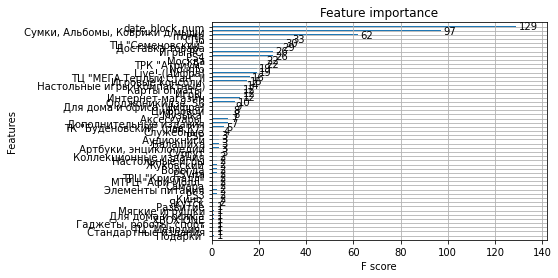

In [35]:
xgboost.plot_importance(model_xgboost)

# Catboost

In [36]:
%%time
model_catboost = catboost.CatBoostRegressor(cat_features=cat_features, loss_function='RMSE')
model_catboost.fit(X_train_no_num, y_train_no_num)

Learning rate set to 0.128853
0:	learn: 1.3009953	total: 684ms	remaining: 11m 23s
1:	learn: 1.2552209	total: 1.15s	remaining: 9m 34s
2:	learn: 1.2180931	total: 1.71s	remaining: 9m 27s
3:	learn: 1.1884685	total: 2.13s	remaining: 8m 49s
4:	learn: 1.1656827	total: 2.5s	remaining: 8m 16s
5:	learn: 1.1474008	total: 2.91s	remaining: 8m 1s
6:	learn: 1.1329751	total: 3.32s	remaining: 7m 50s
7:	learn: 1.1213048	total: 3.71s	remaining: 7m 39s
8:	learn: 1.1123874	total: 4.17s	remaining: 7m 39s
9:	learn: 1.1051156	total: 4.63s	remaining: 7m 38s
10:	learn: 1.0996283	total: 5.06s	remaining: 7m 35s
11:	learn: 1.0947166	total: 5.45s	remaining: 7m 28s
12:	learn: 1.0909223	total: 5.85s	remaining: 7m 24s
13:	learn: 1.0879077	total: 6.28s	remaining: 7m 22s
14:	learn: 1.0853661	total: 6.71s	remaining: 7m 20s
15:	learn: 1.0829868	total: 7.18s	remaining: 7m 21s
16:	learn: 1.0808939	total: 7.59s	remaining: 7m 18s
17:	learn: 1.0787624	total: 7.99s	remaining: 7m 16s
18:	learn: 1.0770665	total: 8.42s	remaining: 

In [37]:
pred_ctb = model_catboost.predict(X_test_no_num)
print(np.sqrt(mean_squared_error(y_test_no_num, pred_ctb)))

1.0473222559313193


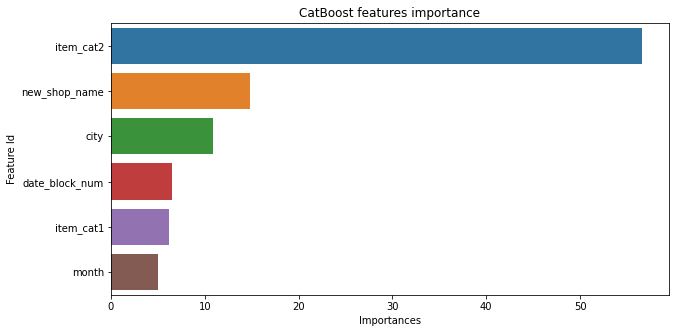

In [38]:
feature_importance_df = pd.DataFrame(model_catboost.get_feature_importance(prettified=True),
                                     columns=['Feature Id', 'Importances'])
plt.figure(figsize=(10, 5))
sns.barplot(x='Importances', y='Feature Id', data=feature_importance_df)
plt.title('CatBoost features importance');

# RandomForest

In [39]:
%%time
model_rf = RandomForestRegressor()
model_rf.fit(X_train_check, y_train_check)

CPU times: user 21min 57s, sys: 444 ms, total: 21min 57s
Wall time: 21min 58s


In [40]:
pred_rf = model_rf.predict(X_test_check)
print(np.sqrt(mean_squared_error(y_test_check, pred_rf)))

1.0571823028248604


# LightGBM

In [41]:
model_lgbm = LGBMRegressor()
model_lgbm.fit(X_train_check, y_train_check)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [42]:
pred_lgbm = model_lgbm.predict(X_test_check)
print(np.sqrt(mean_squared_error(y_test_check, pred_lgbm)))

1.048706763064606


In [43]:
model_lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

# GridSearch

In [0]:
# from sklearn.model_selection import GridSearchCV

In [0]:
# params = {
#     'learning_rate':[0.7, 0.5, 0.3, 0.1, 0.01],
#     'reg_alpha':[0, 1, 1.5, 5],
#     'reg_lambda':[0, 1, 1.5, 5],
#     'num_iterations':[100, 500, 1000],
# }

# best_lgbm = GridSearchCV(LGBMRegressor(), params, cv=5, refit=True)

In [0]:
# best_lgbm.fit(X_train_check, y_train_check)

In [0]:
# pred_best_lgbm = best_lgbm.predict(X_test_check)
# print(np.sqrt(mean_squared_error(y_test_check, pred_best_lgbm)))

# Stacking models

In [0]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR

In [46]:
estimators = [
              ('ridge', RidgeCV()),
              ('lr', LinearRegression()),
              ('svr', LinearSVR()),
              ('xgboost', xgboost.XGBRegressor()),
              # ('rf', RandomForestRegressor())
              ]

stack = StackingRegressor(estimators=estimators, final_estimator=LGBMRegressor())
stack.fit(X_train_check, y_train_check)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[14:39:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

[15:02:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:14:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:17:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


StackingRegressor(cv=None,
                  estimators=[('ridge',
                               RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                       cv=None, fit_intercept=True,
                                       gcv_mode=None, normalize=False,
                                       scoring=None, store_cv_values=False)),
                              ('lr',
                               LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=False)),
                              ('svr',
                               LinearSVR(C=1.0, dual=True, epsilon=0.0,
                                         fit_intercept=True,
                                         intercept_scaling=1.0,
                                         loss...
                                                colsample_bytree=1.0,
                                                importance_type='split',
                  

In [47]:
pred_stack = stack.predict(X_test_check)
print(np.sqrt(mean_squared_error(y_test_check, pred_stack)))

1.08138170381841


In [48]:
import gc
gc.collect()

3389

# Create submission

In [49]:
pred_for_sub = stack.predict(X_test_num)
len(pred_for_sub)

214200

In [50]:
sub = pd.DataFrame({'ID':test.ID, 'item_cnt_month':pred_for_sub})
sub

,ID,item_cnt_month
0,0,1.07619
1,1,1.09123
2,2,1.14036
3,3,1.07266
4,4,1.09123
...,...,...
214195,214195,1.04798
214196,214196,1.04798
214197,214197,1.03403
214198,214198,1.04318


In [0]:
sub.to_csv("sub.csv", index=False)